In [ ]:
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import BaseMessage
from langchain_core.messages import SystemMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, Sequence
from langgraph.prebuilt import ToolNode

load_dotenv()

True

In [34]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [35]:
footballer_goals = {
    "cristiano ronaldo": 952,
    "lionel messi": 892,
    "neymar": 450,
    "kylian mbappe": 300,
    "robert lewandowski": 640,
    "erling haaland": 210
}

@tool(name_or_callable="Footbaler_Goals", description="Useful when getting the total number of goals by a footballer, returns -1 if the footballer name is not found!")
def get_goals(name: str) -> int:
    footballer = name.lower()
    if footballer in footballer_goals:
        return footballer_goals[footballer]
    return -1

@tool(name_or_callable= "Current_Date", description="Useful when knowing about the current date. Returns date in dd/mm/yy format")
def get_date() -> str:
    import datetime
    date = datetime.datetime.now()
    return date.strftime("%d/%m/%y")

In [36]:
tools = [get_goals, get_date]
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash").bind_tools(tools = tools)

In [45]:
def llm_node(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content = "You are a helpful AI assistant, please answer my query")
    # print('State: ', state['messages'])
    result = llm.invoke([system_prompt] + state['messages'])
    # print('Result: ', result)
    return {'messages' : [result]}

def decide_next_node(state: AgentState):
    messages = state['messages']
    if messages[-1].tool_calls:
        return "tool_call"
    return "end"

graph = StateGraph(AgentState)
graph.add_node("llm_node", llm_node)
tool_node = ToolNode(tools=tools)
graph.add_node('tool_node', tool_node)

graph.add_edge(START, "llm_node")
graph.add_conditional_edges(
    "llm_node",
    decide_next_node,
    {
        "tool_call": "tool_node",
        "end": END
    }
)
graph.add_edge("tool_node", "llm_node")

app = graph.compile()

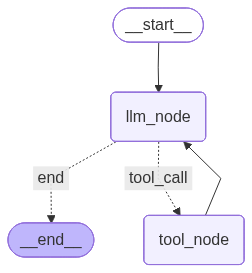

In [38]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message, tuple):
            print(message)
        elif isinstance(message.content, list):
            print("Final result: ", message.content[0]['text'])
        else:
            message.pretty_print()

In [ ]:
inputs = {"messages": [('user', "What is the current date and how many goals did cristiano ronaldo scored?")]}
# result = app.invoke({"messages": [('user', "What is the current date and how many goals did mainak ronaldo scored?")]})
# print(result['messages'][-1].content[0]['text'])

print_stream(app.stream(inputs, stream_mode='values'))

================================ Human Message =================================

What is the current date and how many goals did cristiano ronaldo scored?
================================== Ai Message ==================================
Tool Calls:
  Current_Date (87b028fd-231e-4fde-8bad-1d82b5761f77)
 Call ID: 87b028fd-231e-4fde-8bad-1d82b5761f77
  Args:
  Footbaler_Goals (d35f3482-050f-4da2-887e-5d9ad5af8756)
 Call ID: d35f3482-050f-4da2-887e-5d9ad5af8756
  Args:
    name: cristiano ronaldo
================================= Tool Message =================================
Name: Footbaler_Goals

952
Final result:  The current date is 22/11/25 and Cristiano Ronaldo has scored 952 goals.
